# 2. Correlación entre contaminantes

Usando el archivo generado en el notebook `01_concatenar_archivos.ipynb` se estructura primero el dataframe para correr la función de correlación en python y graficar la matriz correspondiente.

Después se construye una función que servirá para obtener la correlación con un desfase determinado de tiempo.

Dado que son necesarias las correlaciones del O3 y PM10 con los demás contaminantes, se crean nuevos dataframes que se guardarán en archivos csv correspondientes (para usarse en los modelos de predicción) y se graficaran las correlaciones correspondientes.

Se importan las bibliotecas necesarias.

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from pandas.plotting import scatter_matrix

Se carga el archivo generado anteriormente.

In [2]:
data = pd.read_csv("/home/pradel/Desktop/Forecast_CDMX_pollution/datasets/por_hora/contaminantes_hora_12_18.csv")

In [3]:
data.head()

,Unnamed: 0,fecha,hora,dia,mes,id_station,UVA,UVB,PA,CO,...,NOX,O3,PM2.5,PMCO,SO2,RH,TMP,WSP,WDR,PM10
0,0,2014-01-01 01:00:00,1,1,1,ACO,NaN,NaN,NaN,0.3,...,NaN,9.0,NaN,NaN,2.0,89.0,6.8,2.5,323.0,57.0
1,1,2014-01-01 01:00:00,1,1,1,ATI,NaN,NaN,NaN,0.5,...,20.0,9.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,69.0
2,2,2014-01-01 01:00:00,1,1,1,CAM,NaN,NaN,NaN,0.5,...,34.0,5.0,54.0,15.0,14.0,NaN,NaN,NaN,NaN,69.0
3,3,2014-01-01 01:00:00,1,1,1,CHO,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,NaN,5.0,84.0,9.4,1.1,61.0,84.0
4,5,2014-01-01 01:00:00,1,1,1,CUA,NaN,NaN,NaN,1.3,...,54.0,4.0,NaN,NaN,11.0,83.0,7.5,1.3,168.0,83.0


Como se puede observar, se necesita reestructurar el dataframe para que se pueda correr la correlación. Es necesario quitar algunas columnas y reiniciar índices.

## 2.1 Estructuración del dataframe

Se eliminan las columnas `Unnamed:0`, `mes`, `dia` y `hora`, pues no son de nuestra utilidad. También se ordenan los datos por la columna `fecha` de manera ascendente, lo cual es fundamental para que posteriormente se construya la correlación con el desfase de tiempo 

In [4]:
data.drop(['Unnamed: 0', 'mes', 'dia', 'hora'], axis = 1, inplace = True)

In [5]:
data = data.sort_values(by = 'fecha')
data = data.reset_index(drop = True)

In [6]:
data.head()

,fecha,id_station,UVA,UVB,PA,CO,NO,NO2,NOX,O3,PM2.5,PMCO,SO2,RH,TMP,WSP,WDR,PM10
0,2012-01-01 00:00:00,ACO,NaN,NaN,NaN,0.1,1.0,4.0,4.0,24.0,NaN,NaN,1.0,71.0,10.9,3.8,30.0,6.0
1,2012-01-01 00:00:00,MER,0.0,0.0,590.0,0.3,4.0,14.0,18.0,16.0,9.0,7.0,2.0,65.0,12.0,4.0,342.0,16.0
2,2012-01-01 00:00:00,IZT,NaN,NaN,NaN,NaN,0.0,11.0,11.0,18.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,11.0
3,2012-01-01 00:00:00,FAC,NaN,NaN,NaN,0.1,3.0,12.0,16.0,19.0,NaN,NaN,2.0,69.0,11.4,2.7,340.0,14.0
4,2012-01-01 00:00:00,CAM,NaN,NaN,NaN,0.5,4.0,15.0,19.0,15.0,10.0,7.0,1.0,NaN,NaN,NaN,NaN,16.0


Los datos recolectados son de las diferentes estaciones de monitoreo del la Ciudad de México. Se calcula el promedio de los valores sobre todas las estaciones. Esto se logra haciendo un `group by` usando la columna `fecha`. Para mejor visualización de los datos se redondean los valores a la primera cifra decimal.

In [7]:
data = data.groupby('fecha', as_index = False).mean()
data = data.round(1)

In [8]:
data.head()

,fecha,UVA,UVB,PA,CO,NO,NO2,NOX,O3,PM2.5,PMCO,SO2,RH,TMP,WSP,WDR,PM10
0,2012-01-01 00:00:00,0.0,0.0,590.0,0.3,2.6,13.8,16.2,15.1,9.4,6.3,1.6,68.3,11.4,3.2,294.9,14.8
1,2012-01-01 01:00:00,0.0,0.0,587.0,1.4,30.0,39.8,69.5,5.5,77.0,136.9,7.2,68.8,9.7,1.4,180.0,174.3
2,2012-01-01 02:00:00,0.0,0.0,587.0,1.7,39.7,40.0,79.6,4.3,121.0,38.0,8.2,72.6,9.1,1.6,139.6,164.6
3,2012-01-01 03:00:00,0.0,0.0,587.0,1.8,40.8,39.1,79.6,4.6,125.1,36.7,7.6,74.1,8.6,1.1,232.6,172.9
4,2012-01-01 04:00:00,0.0,0.0,587.0,2.0,51.2,37.8,88.9,4.1,129.6,37.0,6.9,75.3,8.2,1.0,225.6,167.6


## 2.2 Correlación entre contaminantes

Usando los datos anteriores ya podemos obtener la correlación y la matriz de correlación entre los contaminantes.

Se construye un filtro para que a demanda el usuario obtenga la correlación del contaminante deseado.

In [9]:
@interact
def correlaciones(X = list(data.select_dtypes('number').columns),
                  Y = list(data.select_dtypes('number').columns)):
        
    print(f"Correlación: {data[X].corr(data[Y])}")

interactive(children=(Dropdown(description='X', options=('UVA', 'UVB', 'PA', 'CO', 'NO', 'NO2', 'NOX', 'O3', '…

Y se construye la matriz de correlación:

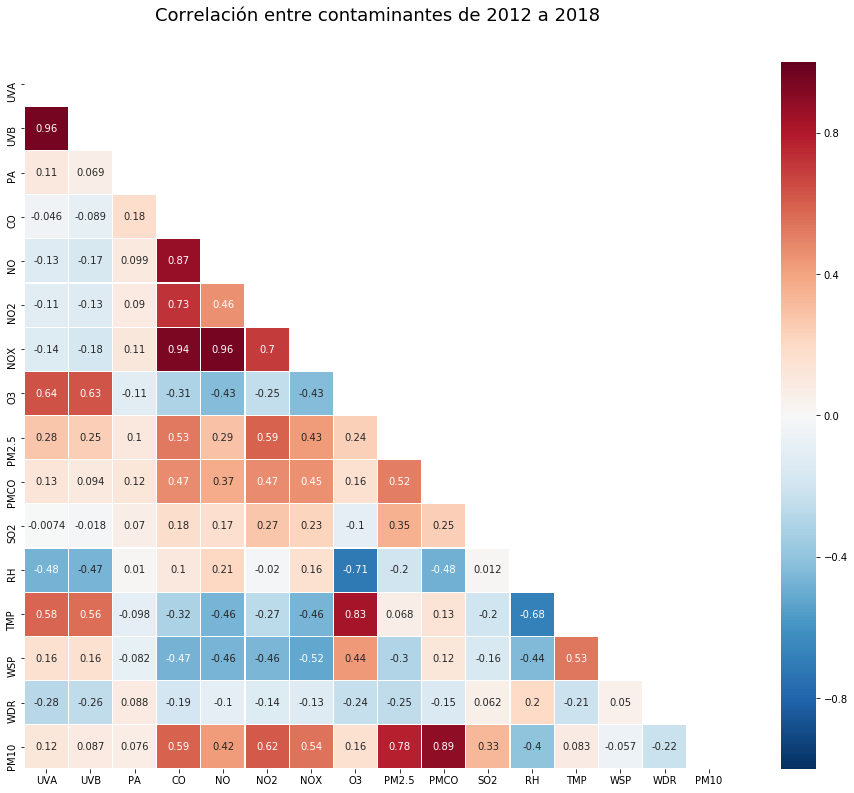

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
colormap = plt.cm.RdBu_r
plt.figure(figsize=(18,13))
plt.title(u'Correlación entre contaminantes de 2012 a 2018', y=1.05, size=18)

mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(data.corr(), mask=mask, linewidths=0.1,vmin = -1.0, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

También se puede graficar la distribución de los datos para visualizar la correlación.

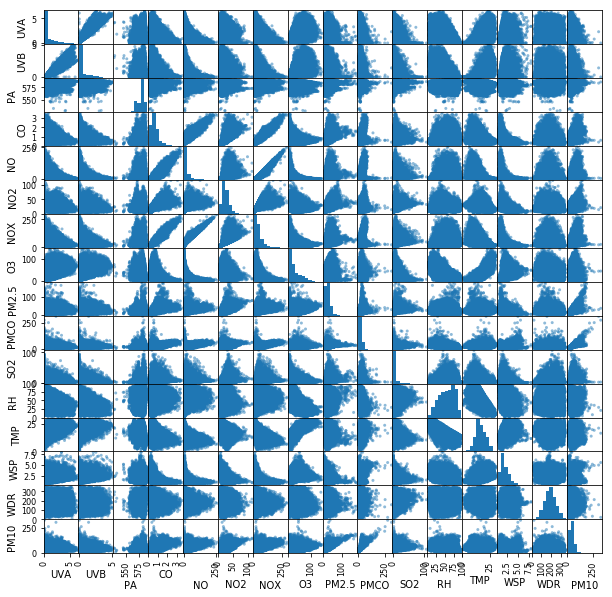

In [14]:
scatter_matrix(data, figsize=(10,10))
plt.show()

## 2.3 Correlación cruzada entre contaminantes

Es necesario conocer la correlación entre los contaminantes a distintos rangos de tiempo. Por ejemplo, es de interés saber si las partículas PM10 aumentan o disminuyen 24 hrs después de que subió el O3 o algún otro contaminante. Para ello se construye una función que calcule la correlación desfasada cada hora.

Esta función fue obtenida en un artículo de kaggle titulado [Cross-correlation (time-lag) with pandas](https://www.kaggle.com/dedecu/cross-correlation-time-lag-with-pandas) y aplicada en este trabajo: 

In [15]:
def data_lag(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
    return df

In [16]:
NON_DER = ['fecha',]

El desfase se hará para 72 horas aplicando la función anterior a los datos que se tienen.

In [17]:
data_72 = data_lag(data, 72, NON_DER)

Se corre la correlación para este desfase y se guarda en un nuevo dataframe.

In [18]:
data_72_corr = data_72.corr()

La tabla obtenida tiene todos los valores desfasados hasta 72 horas. Por ejemplo la columna indicada como PM10_63 muestra la correlación de todos los contaminantes con diferencia de 63 horas.

In [19]:
data_72_corr.head()

,UVA,UVB,PA,CO,NO,NO2,NOX,O3,PM2.5,PMCO,...,PM10_63,PM10_64,PM10_65,PM10_66,PM10_67,PM10_68,PM10_69,PM10_70,PM10_71,PM10_72
UVA,1.000000,0.955603,0.107343,-0.046308,-0.127995,-0.113327,-0.140273,0.637840,0.275274,0.128518,...,-0.107516,-0.050326,-0.003415,0.027705,0.043913,0.051079,0.057823,0.071975,0.099090,0.138198
UVB,0.955603,1.000000,0.069185,-0.089234,-0.166607,-0.131417,-0.177303,0.630521,0.249497,0.093933,...,-0.093488,-0.034817,0.013799,0.044070,0.054896,0.052458,0.047539,0.051735,0.073770,0.113496
PA,0.107343,0.069185,1.000000,0.184217,0.099352,0.089986,0.109460,-0.113144,0.102240,0.120426,...,0.113514,0.107144,0.097463,0.087730,0.079488,0.074966,0.073672,0.074932,0.078084,0.080416
CO,-0.046308,-0.089234,0.184217,1.000000,0.870793,0.726255,0.939619,-0.306954,0.526676,0.470417,...,0.190026,0.152264,0.120292,0.107456,0.122060,0.162429,0.215317,0.263217,0.290071,0.275591
NO,-0.127995,-0.166607,0.099352,0.870793,1.000000,0.460770,0.956901,-0.434313,0.291982,0.373522,...,0.150177,0.123662,0.105905,0.106326,0.129356,0.169737,0.211755,0.236967,0.231434,0.181179


### 2.3.1 Correlación entre PM10 y los demás contaminantes

Siendo las partículas PM10 uno de los determinantes para detonar una contingencia ambiental, interesa saber de que manera se correlacionan con los demás contaminantes y en que ciclos de tiempo dicha correlación es más fuerte.

Se graficará esta correlación para el rango de 0 a 72 horas obtenido en la sección anterior.

Antes de correr la correlación se le vuelve a dar estructura al dataframe para poder graficar de manera óptima.

In [24]:
# Se aísla sólo la columna que corresponde a las partículas PM10
PM10_72 = data_72_corr[["PM10"]]

In [25]:
# Se reinicia el índice del dataframe
PM10_72.reset_index(inplace=True)

In [26]:
# Se renombran las columnas para mayor comprensión
PM10_72.columns = ['contaminante', 'valor']

El dataframe tendrá la siguiente estructura:

In [29]:
PM10_72 .head()

,contaminante,valor
0,UVA,0.123385
1,UVB,0.086852
2,PA,0.076456
3,CO,0.593270
4,NO,0.423978


El índice de este dataframe indica las horas,la columna contaminante junto con la columna valor da la correlación entre el PM10 y el contaminante indicado a la hora indicada. Por ejemplo la fila con índice `29` contaminante `UVA_14` y valor `-0.265479`, nos dice que la correlación del PM10 con los rayos UVA después de 14 horas es de `-0.265479`.

La estructura de este dataframe es poco práctica para poder graficar y obtener un archivo csv con las correlaciones. Por ello se parte primero este dataframe en dos y se trabajará cada uno de manera distinta.

El objetivo es tener un dataframe con columnas `horas`, `UVA`, `UVB`,..., `PM10` y que cada celda represente la correlación a la hora indicada.

Primero separamos las primeras 16 filas de este dataframe en otro más pequeño. El resultante serán los valores de la correlación a la hora 0.

In [30]:
hora_0 = PM10_72.loc[0:15]

In [31]:
# La columna contaminante no sirve para estructurar el nuevo dataframe, por tanto se elimina
hora_0.drop(['contaminante'], axis=1, inplace = True)

In [32]:
# Se transpone la columna pues será la fila 0 (hora cero) del nuevo dataframe
hora_0 = hora_0.transpose()

In [35]:
# Se renombran las columnas para que cada valor coincida con los contaminantes que se tienen
hora_0.columns = ['UVA', 'UVB', 'PA', 'CO', 'NO', 'NO2', 'NOX', 'O3', 'PM25', 'PMCO', 'SO2', 'RH', 'TMP'
                  , 'WSP', 'WDR', 'PM10']

In [36]:
# Se reinicia el índice y visualizamos el nuevo dataframe
hora_0 = hora_0.reset_index(drop=True)
hora_0.head()

,UVA,UVB,PA,CO,NO,NO2,NOX,O3,PM25,PMCO,SO2,RH,TMP,WSP,WDR,PM10
0,0.123385,0.086852,0.076456,0.59327,0.423978,0.615966,0.54328,0.163479,0.779534,0.890058,0.328255,-0.400048,0.083042,-0.056969,-0.224955,1.0


Ahora bien, se trabajará con las siguientes filas del dataframe original, que contiene de la hora 1, a las 72, es deir a partir de la fila 16 del índice.

In [37]:
# Se parte el dataframe original en un nuevo dataframe
hora_72 = PM10_72.loc[16:]

In [38]:
hora_72.shape

(1152, 2)

El nuevo dataframe tiene 1152 filas. El objetivo es obtener un dataframe por cada contaminante. Es decir se tendrá un dataframe para el O3 con los valores de su correlación con el PM10 de 0 a 72 horas y así para cada contaminante. Para ello se dividirá el dataframe `hora_72` en los 16 dataframes correspondientes.

In [40]:
# División del dataframe en los 16 necesarios
dfs_72 = \
{name: group for name, group in hora_72.groupby(np.arange(1152) // 72)}

In [41]:
# Se reinician los índices de los 16 dataframes
for i in range(0,16):
    dfs_72[i] = dfs_72[i].reset_index(drop = True)

Ahora que ya se tienen los 16 dataframes, es necesario "pegarlos" uno al lado de otro de manera que nuestras columnas sean los nombres de los contaminantes y nuestras filas las horas.

In [42]:
hora_72_c = pd.concat({k:v for (k,v) in dfs_72.items()}, axis = 1)

Al hacer la concatenación anterior se crea un multiíndice que no sirve al propósito de este trabajo, así que se elimina.

In [43]:
# Eliminación del multiíndice
hora_72_c.columns = hora_72_c.columns.droplevel()

También todas las columnas que tienen los nombres de los contaminantes no se necesitan, por lo tanto se quitan todas ellas.

In [44]:
# Se quitan columnas innecesarias
hora_72_c.drop(['contaminante'], axis=1, inplace = True)

Se renombran las columnas para que tengan los nombres de los contaminantes

In [46]:
hora_72_c.columns = ['UVA', 'UVB', 'PA', 'CO', 'NO', 'NO2', 'NOX', 'O3', 'PM25', 'PMCO', 'SO2', 'RH'
             , 'TMP', 'WSP', 'WDR', 'PM10']

Esta parte del dataframe queda así:

In [47]:
hora_72_c.head()

,UVA,UVB,PA,CO,NO,NO2,NOX,O3,PM25,PMCO,SO2,RH,TMP,WSP,WDR,PM10
0,0.080427,0.045569,0.069874,0.570131,0.463029,0.545380,0.551671,0.139433,0.716767,0.807673,0.313123,-0.366051,0.032859,-0.125894,-0.196037,0.910002
1,0.059289,0.032672,0.064093,0.490580,0.429512,0.462602,0.497568,0.129914,0.653884,0.692203,0.296921,-0.336802,-0.007738,-0.190272,-0.168074,0.794762
2,0.054171,0.040764,0.062272,0.389135,0.351797,0.391413,0.411625,0.123672,0.593820,0.579211,0.283695,-0.309821,-0.041577,-0.237088,-0.147531,0.679225
3,0.055630,0.056321,0.064430,0.296638,0.263245,0.349949,0.326660,0.110398,0.544313,0.485107,0.278228,-0.285927,-0.069615,-0.272724,-0.130351,0.581328
4,0.052166,0.063484,0.071135,0.238013,0.195251,0.342600,0.269419,0.083539,0.507030,0.418883,0.281921,-0.263285,-0.095153,-0.300617,-0.110642,0.512566


Concatenamos `hora_0` con `hora_72_c` para tener todo el dataframe completo.

In [48]:
PM10_72_df = pd.concat([hora_0, hora_72_c], axis=0, join='outer', ignore_index=True)

Ahora sólo falta crear la columna de horas, basada en el índice para que se pueda graficar.

In [49]:
# Se agrega la columna de horas
horas = PM10_72_df.index
PM10_72_df.insert(loc=0, column='horas', value=horas)

Finalmente el dataframe que se usará para graficar será el siguiente.

In [50]:
PM10_72_df.head()

,horas,UVA,UVB,PA,CO,NO,NO2,NOX,O3,PM25,PMCO,SO2,RH,TMP,WSP,WDR,PM10
0,0,0.123385,0.086852,0.076456,0.593270,0.423978,0.615966,0.543280,0.163479,0.779534,0.890058,0.328255,-0.400048,0.083042,-0.056969,-0.224955,1.000000
1,1,0.080427,0.045569,0.069874,0.570131,0.463029,0.545380,0.551671,0.139433,0.716767,0.807673,0.313123,-0.366051,0.032859,-0.125894,-0.196037,0.910002
2,2,0.059289,0.032672,0.064093,0.490580,0.429512,0.462602,0.497568,0.129914,0.653884,0.692203,0.296921,-0.336802,-0.007738,-0.190272,-0.168074,0.794762
3,3,0.054171,0.040764,0.062272,0.389135,0.351797,0.391413,0.411625,0.123672,0.593820,0.579211,0.283695,-0.309821,-0.041577,-0.237088,-0.147531,0.679225
4,4,0.055630,0.056321,0.064430,0.296638,0.263245,0.349949,0.326660,0.110398,0.544313,0.485107,0.278228,-0.285927,-0.069615,-0.272724,-0.130351,0.581328


Para que los datos anteriores se usen en el modelo de predicción se guardarán en un nuevo archivo csv.

In [52]:
PM10_72_df.to_csv(r'/home/pradel/Desktop/Forecast_CDMX_pollution/correlacion/sub_dataset/corr_pm10_72.csv')

### 2.3.2 Correlación entre O3 y los demás contaminantes

El O3 es otro de los contaminantes cuyos valores determinan las contingencias ambientales. Se repetirá el proceso anterior del PM10 para obtener su correlación desfasada a 73 horas con los demás contaminantes.

Al final también se obtiene un archivo csv y una gráfica para el O3.

In [53]:
# Se aísla sólo la columna que corresponde al O3
O3_72 = data_72_corr[["O3"]]

In [54]:
# Se reinicia el índice del dataframe
O3_72.reset_index(inplace=True)

In [55]:
# Se renombran las columnas para mayor comprensión
O3_72.columns = ['contaminante', 'valor']

El dataframe tendrá la siguiente estructura

In [65]:
O3_72.head()

,contaminante,valor
0,UVA,0.637840
1,UVB,0.630521
2,PA,-0.113144
3,CO,-0.306954
4,NO,-0.434313


Al igual que con el dataframe de las partículas PM10, el del O3 también se separa primero en dos dataframes (la hora cero, y las siguientes 72 horas) y luego se crea un dataframe reestructurado que tiene la columna de `horas`, `UVA`, etc., de manera que cada celda sea el valor de la correlación entre el 03 y los demás contaminantes a la hora determinada.

In [58]:
hora_0_o3 = O3_72.loc[0:15]

In [60]:
# La columna contaminante no sirve para estructurar el nuevo dataframe, por tanto se elimina
hora_0_o3.drop(['contaminante'], axis=1, inplace = True)

In [61]:
# Se transpone la columna pues será la fila 0 (hora cero) del nuevo dataframe
hora_0_o3 = hora_0_o3.transpose()

In [66]:
# Se renombran las columnas para que cada valor coincida con los contaminantes que se tienen
hora_0_o3.columns = ['UVA', 'UVB', 'PA', 'CO', 'NO', 'NO2', 'NOX', 'O3', 'PM25', 'PMCO', 'SO2', 'RH', 'TMP'
                  , 'WSP', 'WDR', 'PM10']

In [68]:
# Se reinicia el índice y visualizamos el nuevo dataframe
hora_0_o3 = hora_0_o3.reset_index(drop=True)
hora_0_o3.head()

,UVA,UVB,PA,CO,NO,NO2,NOX,O3,PM25,PMCO,SO2,RH,TMP,WSP,WDR,PM10
0,0.63784,0.630521,-0.113144,-0.306954,-0.434313,-0.248507,-0.43146,1.0,0.236128,0.157639,-0.100684,-0.71309,0.828244,0.436042,-0.240342,0.163479


Ahora bien, se trabajará con las siguientes filas del dataframe original, que contiene de la hora 1, a las 72, es deir a partir de la fila 16 del índice.

In [69]:
# Se parte el dataframe original en un nuevo dataframe
hora_72_o3 = O3_72.loc[16:]

In [70]:
hora_72_o3.shape

(1152, 2)

In [71]:
# División del dataframe en los 16 necesarios
dfs_72_o3 = \
{name: group for name, group in hora_72_o3.groupby(np.arange(1152) // 72)}

In [72]:
# Se reinician los índices de los 16 dataframes
for i in range(0,16):
    dfs_72_o3[i] = dfs_72_o3[i].reset_index(drop = True)

In [73]:
# Se concatenan los dataframes
hora_72_o3_c = pd.concat({k:v for (k,v) in dfs_72_o3.items()}, axis = 1)

In [74]:
# Eliminación del multiíndice
hora_72_o3_c.columns = hora_72_o3_c.columns.droplevel()

In [75]:
# Se quitan columnas innecesarias
hora_72_o3_c.drop(['contaminante'], axis=1, inplace = True)

In [76]:
hora_72_o3_c.columns = ['UVA', 'UVB', 'PA', 'CO', 'NO', 'NO2', 'NOX', 'O3', 'PM25', 'PMCO', 'SO2', 'RH'
             , 'TMP', 'WSP', 'WDR', 'PM10']

In [77]:
hora_72_o3_c.head()

,UVA,UVB,PA,CO,NO,NO2,NOX,O3,PM25,PMCO,SO2,RH,TMP,WSP,WDR,PM10
0,0.765118,0.754990,-0.080702,-0.185457,-0.324120,-0.147038,-0.309422,0.940698,0.339028,0.186335,-0.055020,-0.671755,0.773337,0.310311,-0.302206,0.216998
1,0.802419,0.785276,-0.047122,-0.026367,-0.160734,-0.025243,-0.137854,0.797727,0.416837,0.230587,-0.005294,-0.579908,0.655618,0.179131,-0.341931,0.282632
2,0.751001,0.723153,-0.017447,0.147529,0.037981,0.093016,0.061036,0.600658,0.463512,0.275272,0.043611,-0.449511,0.490207,0.043993,-0.354826,0.344972
3,0.626829,0.587267,0.004856,0.304057,0.238007,0.187485,0.253198,0.380821,0.475369,0.304647,0.084618,-0.296354,0.296871,-0.088001,-0.341393,0.387392
4,0.455845,0.407692,0.017581,0.413766,0.404089,0.244005,0.405581,0.166247,0.452752,0.306708,0.112308,-0.137781,0.097090,-0.209065,-0.306782,0.397620


Concatenamos `hora_0_o3` con `hora_72_o3_c` para tener todo el dataframe completo.

In [78]:
O3_72_df = pd.concat([hora_0_o3, hora_72_o3_c], axis=0, join='outer', ignore_index=True)

In [79]:
# Se agrega la columna de horas
horas = O3_72_df.index
O3_72_df.insert(loc=0, column='horas', value=horas)

Finalmente el dataframe queda así:

In [80]:
O3_72_df.head()

,horas,UVA,UVB,PA,CO,NO,NO2,NOX,O3,PM25,PMCO,SO2,RH,TMP,WSP,WDR,PM10
0,0,0.637840,0.630521,-0.113144,-0.306954,-0.434313,-0.248507,-0.431460,1.000000,0.236128,0.157639,-0.100684,-0.713090,0.828244,0.436042,-0.240342,0.163479
1,1,0.765118,0.754990,-0.080702,-0.185457,-0.324120,-0.147038,-0.309422,0.940698,0.339028,0.186335,-0.055020,-0.671755,0.773337,0.310311,-0.302206,0.216998
2,2,0.802419,0.785276,-0.047122,-0.026367,-0.160734,-0.025243,-0.137854,0.797727,0.416837,0.230587,-0.005294,-0.579908,0.655618,0.179131,-0.341931,0.282632
3,3,0.751001,0.723153,-0.017447,0.147529,0.037981,0.093016,0.061036,0.600658,0.463512,0.275272,0.043611,-0.449511,0.490207,0.043993,-0.354826,0.344972
4,4,0.626829,0.587267,0.004856,0.304057,0.238007,0.187485,0.253198,0.380821,0.475369,0.304647,0.084618,-0.296354,0.296871,-0.088001,-0.341393,0.387392


Para que los datos anteriores se usen en el modelo de predicción se guardarán en un nuevo archivo csv.

In [81]:
O3_72_df.to_csv(r'/home/pradel/Desktop/Forecast_CDMX_pollution/correlacion/sub_dataset/corr_o3_72.csv')